# GCN with Pytorch Geometric on Cora Datasets 
[video Pytorch Geometric](https://www.youtube.com/watch?v=ex2qllcVneY)

## Load datasets and library

In [1]:
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import networkx
import matplotlib.pyplot as plt
import numpy as np 


In [2]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
dataset

Cora()

In [3]:
# Get some basic info about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50*'=')

# There is only one graph in the dataset, use it as new data object
data = dataset[0]  

# Gather some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


In [4]:
data.x.size()

torch.Size([2708, 1433])

In [5]:
G = torch_geometric.utils.to_networkx(data)

In [6]:
A = networkx.linalg.adjacency_matrix(G)

In [7]:
n_class = len(torch.unique(data.y))
print('There is',n_class,'classes for the Cora citation dataset')

There is 7 classes for the Cora citation dataset


In [8]:
data.val_mask.sum()

tensor(500)

In [9]:
data.val_mask

tensor([False, False, False,  ..., False, False, False])

## Is MLP sufficient for this task ? 
First we want to see the performance for a simple 2 layer MLP apply on graph structure data for node classification

In [10]:
# Simple MLP

class MLP(nn.Module):
    def __init__(self,dim_in,dim_h,n_class) -> None:
        super(MLP,self).__init__()

        
        self.linear1 = nn.Linear(dim_in,dim_h)
        self.linear2 = nn.Linear(dim_h,40)
        self.linear3 = nn.Linear(40,n_class)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.softmax = nn.Softmax(dim=1)

    
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        #x = self.dropout(x)
        y = self.linear2(x)
        y = self.relu(y)
        y = self.linear3(y)
        #y = self.softmax(x)

        return y


In [11]:
# implement a simple dataset for the mlp 


class cora_dataset(torch.utils.data.Dataset):
    def __init__(self,data,mode='train'):

        if mode =='train':
            mask = data.train_mask

        elif mode =='val':
            mask = data.val_mask
        else:
            mask = data.test_mask
        self.data = data.x[mask] 
        self.labels = data.y[mask]


    def __getitem__(self,index):

        return self.data[index],self.labels[index]

    def __len__(self):
        return len(self.labels)

In [12]:
dataset_train = cora_dataset(data,mode='train')
dataset_val = cora_dataset(data,mode='val')
dataset_test = cora_dataset(data,mode='test')
bs = 80
train_loader = torch.utils.data.DataLoader(dataset_train,batch_size=bs,shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val,batch_size=bs,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test,batch_size=bs,shuffle=True)

In [13]:
learning_rate = 0.01
model = MLP(data.x.size()[1],200,n_class)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
n_epoch = 60

In [14]:
loss_train = []
loss_val = []
tmp = []
for ep in range(n_epoch):
    print('EPOCHS:',ep)

    for i,(x,y) in enumerate(train_loader):
        model.train()
        pred = model(x)

        loss = criterion(pred,y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        tmp.append(loss.item())

    loss_train.append(np.array(tmp).mean())
    tmp = []
    print('Loss train',loss_train[ep])

    for i,(x,y) in enumerate(val_loader):
        model.eval()

        pred = model(x)

        loss = criterion(pred,y)
        tmp.append(loss.item())
        
    loss_val.append(np.array(tmp).mean())
    print('Loss val',loss_val[ep])
    tmp = []


EPOCHS: 0
Loss train 1.9505767226219177
Loss val 1.9276932988848006
EPOCHS: 1
Loss train 1.9370410442352295
Loss val 1.930970243045262
EPOCHS: 2
Loss train 1.9095973372459412
Loss val 1.922567503792899
EPOCHS: 3
Loss train 1.8618689179420471
Loss val 1.9158486468451363
EPOCHS: 4
Loss train 1.777590811252594
Loss val 1.9124318531581335
EPOCHS: 5
Loss train 1.6585552096366882
Loss val 1.9059474127633231
EPOCHS: 6
Loss train 1.5016416907310486
Loss val 1.879953486578805
EPOCHS: 7
Loss train 1.2900460362434387
Loss val 1.835620437349592
EPOCHS: 8
Loss train 1.0711381435394287
Loss val 1.8007461173193795
EPOCHS: 9
Loss train 0.8314169645309448
Loss val 1.7684934820447649
EPOCHS: 10
Loss train 0.6173416972160339
Loss val 1.7538680178778512
EPOCHS: 11
Loss train 0.4149414896965027
Loss val 1.6892957857676916
EPOCHS: 12
Loss train 0.2554708793759346
Loss val 1.6598799739565169
EPOCHS: 13
Loss train 0.14846189320087433
Loss val 1.637626784188407
EPOCHS: 14
Loss train 0.07723142206668854
Loss va

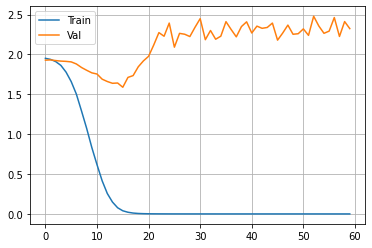

In [15]:
fig, ax = plt.subplots()
ax.plot(np.arange(n_epoch),loss_train, label='Train')
ax.plot(np.arange(n_epoch),loss_val, label='Val')
ax.legend()
ax.grid()

The model overfit but is unable to learn efficient parameters for this task. We're forced to exploit the graph structure! 

In [16]:
model.eval()
pred_test = model(data.x[data.test_mask])
softmax = nn.Softmax(dim=1)
pred_test = softmax(pred_test)
classif = pred_test.argmax(dim=1)
acc = ((classif == data.y[data.test_mask]).sum())/1000
print('The model has an accuracy of',round(acc.item()*100,3),'% on test set')

The model has an accuracy of 46.2 % on test set


## Implement a simple GCN with Pytorch Geometric 

In [17]:
from torch_geometric.nn import GCNConv # importing GCNConv Layer

In [34]:
import torch.nn.functional as F
class GCN(nn.Module):
    def __init__(self,dim_in,dim_h,n_class) -> None:
        super(GCN,self).__init__()

        self.gcnconv1 = GCNConv(dim_in,dim_h)
        self.gcnconv2 = GCNConv(dim_h,n_class)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()

    def forward(self,data):
        x,edge_index = data.x,data.edge_index
        x = self.gcnconv1(x,edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.gcnconv2(x,edge_index)

        return x


In [47]:
gcn_model = GCN(data.x.size()[1],16,n_class)

In [48]:
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
n_epoch = 200
criterion = nn.CrossEntropyLoss()
loss_train = []
loss_val = []
acc_train = []
acc_val = []
for ep in range(n_epoch):
    # TRAIN
    gcn_model.train()
    optimizer.zero_grad()
    pred = gcn_model(dataset[0])


    loss = criterion(pred[data.train_mask],data.y[data.train_mask])

    loss.backward()
    optimizer.step()

    loss_train.append(loss.item())


    
    # VAL 
    gcn_model.eval()

    loss = criterion(pred[data.val_mask],data.y[data.val_mask])
    loss_val.append(loss.item())

    # Compute accuracy
    pred = pred.argmax(dim=1)

    correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    acc = int(correct) / int(data.train_mask.sum())
    acc_train.append(acc)

    
    correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
    acc = int(correct) / int(data.val_mask.sum())
    acc_val.append(acc)


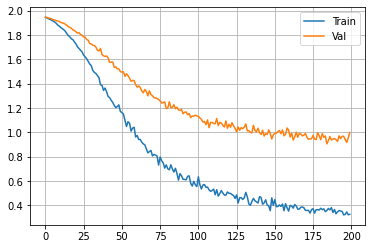

In [49]:
fig, ax = plt.subplots()
ax.plot(np.arange(n_epoch),loss_train, label='Train')
ax.plot(np.arange(n_epoch),loss_val, label='Val')
ax.legend()
ax.grid()

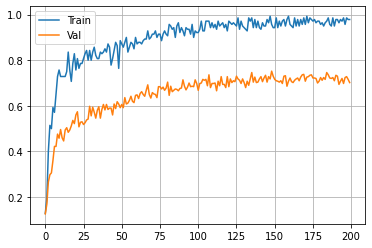

In [50]:
fig, ax = plt.subplots()
ax.plot(np.arange(n_epoch),acc_train, label='Train')
ax.plot(np.arange(n_epoch),acc_val, label='Val')
ax.legend()
ax.grid()

In [52]:
pred = gcn_model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print('Accuracy: {:.2f} % on test set'.format(acc*100))

Accuracy: 80.70 % on test set


It's crucial to use graph structure data to perform on the node classification task